# Classification des critiques des films

* Dataset: [source sur kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) ou [lien stanford](http://ai.stanford.edu/~amaas/data/sentiment/)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%config IPCompleter.greedy = True
%matplotlib inline

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import contractions


In [3]:
# ! pip install kaggle
# To use Kaggle API you need first to get your token:
# - log in to kaggle.com
# - go to your profile page
# - scroll down to the API section
# - click "Create new API tocken" to get your kaggle.json file

In [4]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# import zipfile, os

# data_file = "imdb-dataset-of-50k-movie-reviews.zip"
# with zipfile.ZipFile(data_file,"r") as zip_ref:
#     zip_ref.extractall("data/")
# os.remove(data_file)

In [9]:
df = pd.read_csv("./data/IMDB dataset.csv")
df.shape

(50000, 2)

In [10]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

TODO :

* Nettoyez les reviews.
* Vectorisez les reviews.
* Choisissez la métrique pour évaluer le modèle.
* Utilisez les algorithmes suivants : `LogisticRegression`, `RandomForestClassifier`, `LinearSVC`, `MultinomialNB`
* Mesurez la qualité des modèles sur les ensembles d'entraînement et de test
* Comparez les prédictions de vos modèles sur une dizaine de reviews de votre choix

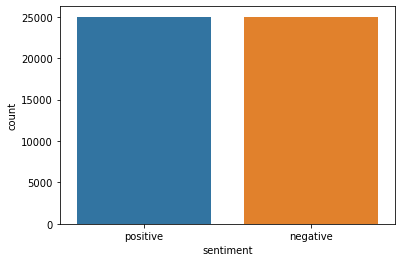

<Figure size 1152x504 with 0 Axes>

In [12]:
sns.countplot(df['sentiment'])
plt.figure(figsize=(16,7))
plt.show()

## Data cleaning

In [37]:
# ! pip install contractions

In [17]:
def cleaning_sentiment(df,col_name):
    porter = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    w = df[col_name].apply(lambda x :x.lower())
    w = w.apply(lambda x: re.sub('(<.*?>)|(\n)|([^\w\s\.\,])|([_])|([.])|([,])|(\s\s+)|([ا-ي])','',x))
    w = w.apply(lambda x: contractions.fix(x))
    w = w.apply(lambda x: ' '.join([porter.stem(i) for i in word_tokenize(x) if i not in stop_words]))
    return w


* Chaque mot est transformer en miniscule avec lower.
* on utilise une expression reguliere pour remplacer  : les balise html, les retour a la ligne, les caractere spéciaux qui ne sont pas des point ou des virgule  (par exemple, !, ?, :) ,les underscore, les points, les virgules, les espace multiple et les mots non anglais par un espace vide
* on supprime toutes les contraction (example: can't devient can not et it's devient it is) .
* chaque mot qui n'est pas un stop_word (and, or, but, etc) est tokenizer et on retour sa basse (ex : terreste devient terre)


In [18]:
df['review'] = cleaning_sentiment(df,'review')

In [15]:
df['review'][:2]

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
Name: review, dtype: object

## Vectorisation avec TF-IDF

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [240]:
X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f' train {X_train.shape}')
print(f' test {X_test.shape}')

 train (45000,)
 test (5000,)


In [241]:
tfidf_vector = TfidfVectorizer(stop_words='english', max_features=None, max_df=0.5, min_df=2, ngram_range=(1,1))

X_train = tfidf_vector.fit_transform(X_train)
X_test = tfidf_vector.transform(X_test)

## Model

## 1- Logistic regression

In [242]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [243]:
lr = LogisticRegression(random_state=42)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [244]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.90      0.87      0.89      2481
    positive       0.88      0.91      0.89      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [245]:
coef_abs = abs(lr.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
lr_best_index = feature_scores[:10].index


for index in lr_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 52420 : {'worst'}
 feature : 50984 : {'wast'}
 feature : 4079 : {'aw'}
 feature : 4332 : {'bad'}
 feature : 19864 : {'great'}
 feature : 15646 : {'excel'}
 feature : 6437 : {'bore'}
 feature : 36341 : {'poor'}
 feature : 46420 : {'terribl'}
 feature : 32771 : {'noth'}


## 2-Random forest

In [246]:
from sklearn.ensemble import RandomForestClassifier

In [247]:
rf = RandomForestClassifier(min_samples_split=5 ,max_depth=10, random_state=42)
rf = rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)

In [248]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

    negative       0.86      0.79      0.83      2481
    positive       0.81      0.87      0.84      2519

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.83      5000
weighted avg       0.84      0.83      0.83      5000



In [249]:
# Obtenir les index des importances de fonctionnalités pour chaque classe
feature_scores = pd.Series(rf.feature_importances_).sort_values(ascending=False)
rf_best_index = feature_scores[:10].index
for index in rf_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 52420 : {'worst'}
 feature : 4332 : {'bad'}
 feature : 19864 : {'great'}
 feature : 4079 : {'aw'}
 feature : 6437 : {'bore'}
 feature : 46420 : {'terribl'}
 feature : 15646 : {'excel'}
 feature : 50984 : {'wast'}
 feature : 35285 : {'perfect'}
 feature : 30559 : {'money'}


## 3-LinearSV

In [250]:
from sklearn.svm import LinearSVC

In [251]:
svm = LinearSVC(random_state=42)
svm = svm.fit(X_train, y_train)
y_pred3 = svm.predict(X_test)

In [252]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      2481
    positive       0.89      0.91      0.90      2519

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [253]:
coef_abs = abs(svm.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
svm_best_index = feature_scores[:10].index


for index in svm_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 52420 : {'worst'}
 feature : 50984 : {'wast'}
 feature : 989 : {'710'}
 feature : 801 : {'410'}
 feature : 4079 : {'aw'}
 feature : 1056 : {'810'}
 feature : 15646 : {'excel'}
 feature : 6437 : {'bore'}
 feature : 36341 : {'poor'}
 feature : 12882 : {'disappoint'}


## 4- MultinomialNB

In [254]:
from sklearn.naive_bayes import MultinomialNB


In [255]:
nb = MultinomialNB()
nb = nb.fit(X_train, y_train)
y_pred4 = nb.predict(X_test)

In [256]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      2481
    positive       0.87      0.87      0.87      2519

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [257]:
coef_abs = abs(nb.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
nb_best_index = feature_scores[:10].index


for index in nb_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


 feature : 5935 : {'bleacher'}
 feature : 51229 : {'weatherbr'}
 feature : 23105 : {'impecuni'}
 feature : 14661 : {'ellari'}
 feature : 6990 : {'broceliand'}
 feature : 32083 : {'neptun'}
 feature : 32082 : {'nepotist'}
 feature : 6994 : {'brocéliand'}
 feature : 6999 : {'brodzki'}
 feature : 6984 : {'broadmind'}
